# LSTM RNN MODEL DEMO WITH AAPL

In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from sklearn import preprocessing
from datetime import datetime, timedelta
import time
from collections import Counter
import os


Using TensorFlow backend.


In [29]:
##### HELPERS #####
def earliest_date_after(query_date, date_list):
    ''' find the earliest date after a query date from ordered list of dates '''
    for i in range(len(date_list)):
        if query_date < date_list[i].date():
            return date_list[i].date()
    print('\nQUERY DATE ERROR WITH:{}'.format(query_date)) 

    raise Exception('No values after query date')

def latest_date_before(query_date, date_list):
    ''' find the latest date before a query date from ordered list of dates '''
    for i in range(len(date_list)):
        if query_date < date_list[i].date():
            if i==0:
                print ('\nQUERY DATE ERROR WITH:{}'.format(query_date)) 
                raise Exception('No values before query date in list')
            return date_list[i-1].date()
        
def inv_price_transform(normalized_data, scaler):
    ''' inverse from normalized price to raw price '''
    m = scaler.mean_[0]
    s = scaler.scale_[0]
    return s*np.array(normalized_data)+m

# Load Data

In [39]:
def prep_data(ticker,
              stock_file = 'data/stock/prices-split-adjusted.csv', \
              news_directory = 'data/news/', \
              econ_file = 'data/market/economic_indicators.csv', \
              reddit_file = 'data/market/reddit_sentiments.csv'):
    ''' merge stock closing price data, sec filing data, and newspaper sentiment into one dataframe '''
    
    # load data
    stock_df = pd.read_csv(stock_file, index_col=0)
    stock_df = stock_df[stock_df.symbol==ticker].close
    stock_df.index = pd.to_datetime(stock_df.index)
    news_df = pd.read_csv(news_directory+ticker+'.csv', index_col=0)
    news_df.index = pd.to_datetime(news_df.index)
    econ_df = pd.read_csv(econ_file, index_col=0)
    econ_df.index = pd.to_datetime(econ_df.index)
    reddit_df = pd.read_csv(reddit_file, index_col=0)
    reddit_df.index = pd.to_datetime(reddit_df.index)
    return_df = pd.DataFrame(columns=[stock_df.name]+['stock_'+a for a in list(news_df.columns)]+\
                             list(econ_df.columns)+['market_'+a for a in list(reddit_df.columns)])
    
    # clip price data that doesn't have news coverage or reddit coverage
    d0, d1 = news_df.index[0].date(), news_df.index[1].date()
    startdate = d0-(d1-d0)
    stock_df = stock_df.loc[startdate:]
    
    # iterate through rows, aggregating all data and appending to return_df
    for row_num in range(stock_df.shape[0]):
        new_row = []
        stock_date = stock_df.index[row_num].date()
        new_row += [stock_df.iloc[row_num]]
        new_row += list(news_df.loc[earliest_date_after(stock_date, news_df.index),:])
        new_row += list(econ_df.loc[latest_date_before(stock_date, econ_df.index),:])
        new_row += list(reddit_df.loc[earliest_date_after(stock_date, reddit_df.index),:])
        return_df.loc[stock_date] = new_row
        if row_num % 100 == 0:
            print(" rows done.{}".format(row_num, stock_df.shape[0]))
    print("\n dataframe prepped.  timepoints, each with  features.{}{}{}".format(ticker, return_df.shape[0], return_df.shape[1]))
    return return_df

# practice with AAPL stock data
aapl_df = prep_data('AAPL')

 rows done.0
 rows done.100
 rows done.200
 rows done.300
 rows done.400
 rows done.500
 rows done.600
 rows done.700
 rows done.800
 rows done.900
 rows done.1000
 rows done.1100
 rows done.1200
 rows done.1300

 dataframe prepped.  timepoints, each with  features.AAPL139514


In [6]:
# display head of X dataframe
aapl_df.head()

,close,stock_polarity,stock_subjectivity,stock_pos,stock_neg,stock_neu,CCI,BCI,CLI,market_neg,market_neu,market_pos,market_polarity,market_subjectivity
2011-06-17,45.751427,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-20,45.045715,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-21,46.471428,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-22,46.087143,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368
2011-06-23,47.318573,-0.049008,0.085913,0.044214,0.058143,0.897643,100.4414,100.4065,99.7851,0.161208,0.184446,0.054288,-0.000445,0.229368


In [17]:
def load_stock(df, lookback=25):
    ''' scale data and split into training/test sets '''
    data = df.values
    n_train = list(df.index).index(df.index[-1]+timedelta(-365))
    scaler = preprocessing.StandardScaler() #normalize mean-zero, unit-variance
    scaler.fit(data[:n_train,:])
    data = scaler.transform(data)
    dataX, dataY = [], []
    for timepoint in range(data.shape[0]-lookback):
        dataX.append(data[timepoint:timepoint+lookback,:])
        dataY.append(data[timepoint+lookback,0])
    X_train, X_test = dataX[:n_train], dataX[n_train:]
    y_train, y_test = dataY[:n_train], dataY[n_train:]
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# load practice stock, AAPL
lookback = 25
X_train, y_train, X_test, y_test, scaler = load_stock(df=aapl_df, lookback=lookback)

training examples, test examples 1142 228


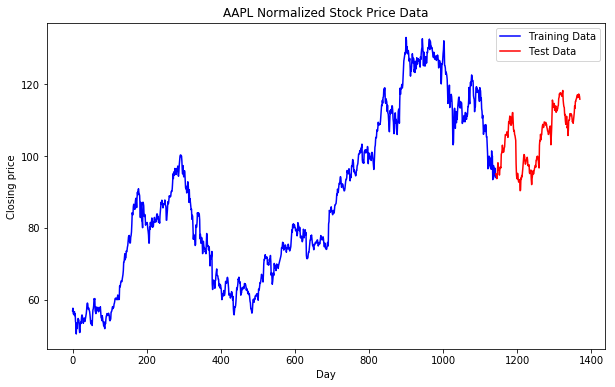

In [36]:
# denormalize training and test price data and plot
print ("training examples, test examples {} {}".format(len(y_train),len(y_test)))

fig, host = plt.subplots(figsize=(10,6))
host.plot(range(len(y_train)), inv_price_transform(y_train, scaler), c='b', label='Training Data')
host.plot(range(len(y_train),len(y_test)+len(y_train)), inv_price_transform(y_test, scaler), c='r', label='Test Data')
host.set_title('AAPL Normalized Stock Price Data')
host.set_xlabel('Day')
host.set_ylabel('Closing price')
plt.legend()
plt.show()


# Train LSTM RNN

In [19]:
# build model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
#model.add(Dense(32, kernel_initializer="uniform", activation='relu'))        
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25, 128)           73216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 204,929
Trainable params: 204,929
Non-trainable params: 0
_________________________________________________________________


In [22]:
# fit model
t0 = time.time()
history = model.fit(
            X_train,
            y_train,
            batch_size=512,
            epochs=200,
            validation_split=0.05,
            verbose=0)
print ("TRAINING DONE .seconds to train.{}".format(int(time.time()-t0)))

TRAINING DONE .seconds to train.160


In [25]:
##### SAVE MODEL #####
model.save('model/model1.h5')

# Predict Future Prices

In [27]:
#### LOAD MODEL #####
model = load_model('model/model1.h5')

RMSE: 0.41517327969244994


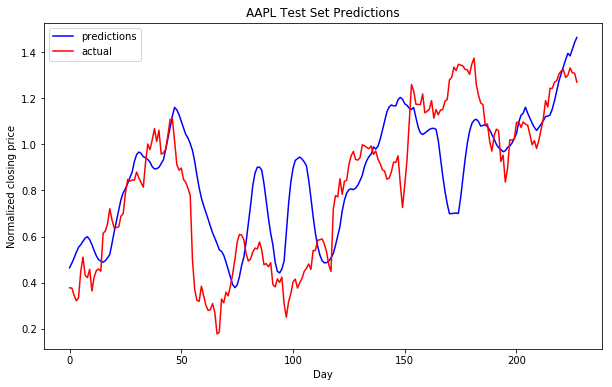

In [38]:
# predict test set
predictions = model.predict(X_test)
print("RMSE: {}".format(np.sqrt(np.mean((predictions-y_test)**2))))

fig, host = plt.subplots(figsize=(10,6))
host.plot(predictions, c='b', label='predictions')
host.plot(y_test, c='r', label='actual')
host.set_ylabel('Normalized closing price')
host.set_xlabel('Day')
host.set_title('AAPL Test Set Predictions')
plt.legend()
plt.show()